<h1>An application of the deep_neural_net_1 script for predicting fake news headlines.</h1>
<br>
<li>The training set contains 2000 training examples.</li>
<li>The dev set contains 500 examples.</li>

<p>By <a href='https://github.com/hrushikeshrv'>hrushikeshrv</a> on GitHub.</p>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [5]:
def help ():
    """
    Returns some helpful information on how to use
    """
    print('#'*5 + '-'*100 + '#'*5)
    print('\n\n')
    print('You will need to decide on the following hyperparameters to initialize your model - \n\n')
    print('The architecture of your model. \n\t Decide on the number of layers your network will have, and the number of units in each of these layers. \n')
    print('The activation functions to use in each layer. \n\t Most often you will want to use a ReLU activation for the hidden units and a sigmoid or softmax activation for the output.\n')
    print('The learning rate alpha of your model. \n\t Use a small number like 0.01, but not too small or gradient descent won\'t converge on the global minima. If you use too big a value, gradient descent can start to diverge.\n')
    print('The number of iterations of gradient descent you want to run. \n\t This model currently only supports gradient descent as an optimization algorithm, but I will be adding other optimizers like ADAM, RMS Prop, and Momentum soon.\n')
    print('\n')
    print('#'*5 + '-'*100 + '#'*5)
    print('\n\nIf you\'re working locally, make sure you have numpy and matplotlib installed.')
    print('\n')
    print('To build a pre-implemented logistic or softmax network, call the \'four_layer_logistic()\' or \'five_layer_logistic()\' functions and pass them the parameters they need.\n\n')
    print('To build a general network, simply call the model() function and pass it the parameters it needs. Have your input data and your output labels prepared and formatted how you want before you initialize.')
    print('Calling the model() function will begin training your given network on your given dataset for a default of 10,000 iterations\n')
    print('It will print the cost and the training accuracy of your model after it is done training.\n\n')
    print('#'*5 + '-'*100 + '#'*5)
    print('\n')

In [6]:
def sigmoid (Z):
    """
    Takes in a real number or matrix Z and applies the sigmoid function to it.
    """
    A = 1/(1+np.exp(-1*Z))
    return A

def relu (Z):
    """
    Takes in a real number or matrix Z and applies the (leaky) relu function to it.
    """
    A = np.zeros(Z.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if Z[i,j] >= 0:
                A[i,j] = Z[i,j]
            else:
                A[i,j] = 0.001*Z[i,j]
    return A

#NOTE ---- THIS DEFINITION MIGHT CAUSE BROADCASTING PROBLEMS DURING RUNTIME
#NOTE 2.0 --- Probably fixed it.
def drelu (Z):
    """
    Takes in a real number Z and returns the derivative of the relu function at that value or matrix.
    Used for back propagation. Z will be the activation value of the last layer before the non-linearity is applied.
    """
    A = np.zeros(Z.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if Z[i,j] >= 0:
                A[i,j] = 1
            else:
                A[i,j] = 0.001
    return A

def softmax (Z):
    """
    Takes in a vector Z and returns its softmax activation.
    """
    temp = np.exp(Z)
    factor = np.sum(temp)
    A = temp/factor
    return A


In [7]:
def initialize_parameters (architecture = []):
    """
    Initializes the parameters of the neural net.
    
    Takes in the architecture of the network as a list.
    Structure the list as the number of units in each layer, starting from the number of input features, to the number of output units.
    [10, 5, 5, 4, 3] means that there are 10 input features, 3 hidden layers with 5, 5, 4 hidden units respectively, and 3 output units (softmax regression)

    Returns a dictionary of keys W(i) for i from 1 to number of layers, and b(i) for the same i.
    """
    parameters = {}

    number_of_layers = len(architecture) - 1

    for i in range(1,number_of_layers+1):

        parameters['W' + str(i)] = np.random.randn(architecture[i], architecture[i-1])*0.01
        parameters['b' + str(i)] = np.zeros((architecture[i], 1))
    
    return parameters


In [8]:
def forward_propagation (X, parameters, num_layers, activation_func = []):
    """
    Performs forward propagation

    Takes in the activations of each layer and the parameters.
    activation_func is a list with as many elements (strings - either relu, softmax, or sigmoid) as number of layers (excluding the input layer)
    num_layers is the number of layers
    parameters is a dictionary containing all the W and b values for all the layers.
    X is the input

    Returns the final prediction y_hat and all the Z and A values as cache to use for backward propagation.
    """
    activations = {'A0': X}

    for i in range(1, num_layers+1):
        W = parameters['W' + str(i)]
        b = parameters['b' + str(i)]

        activations['Z' + str(i)] = np.dot(W, activations['A' + str(i-1)]) + b
        
        if activation_func[i-1].lower() == 'relu':
            activations['A' + str(i)] = relu(activations['Z' + str(i)])

        elif activation_func[i-1].lower() == 'softmax':
            activations['A' + str(i)] = softmax(activations['Z' + str(i)])

        elif activation_func[i-1].lower() == 'sigmoid':
            activations['A' + str(i)] = sigmoid(activations['Z' + str(i)])
        
        activations['W' + str(i)] = W
        activations['b' + str(i)] = b

    return activations['A' + str(num_layers)], activations


In [9]:
def calculate_cost (Y, prediction, activation_output = 'sigmoid'):
    """
    Calculates the cost.

    Takes in the output labels and the prediction from forward propagation, as well as the activation function of the output layer.
    Returns the cost.

    The inputs will be real numbers or row vectors of the same dimensions if the activation function of the last layer is sigmoid.
    The inputs will be row vectors or row matrices of the same dimensions if the activation function of the last layer is softmax.
    """
    m = Y.shape[1]
    
    #------------------------------DEBUG------------------------------#
    #print(f'The prediction A is {prediction}, the label Y is {Y}')
    #------------------------------DEBUG------------------------------#

    if activation_output.lower() == 'sigmoid':
        cost = (-1/m)*np.sum(Y*np.log(prediction) + (1-Y)*np.log(1-prediction))

    if activation_output.lower() == 'softmax':
        cost = (-1/m)*np.sum(np.sum(Y*np.log(prediction), axis = 0, keepdims = True))

    return cost


In [10]:
def backward_propagation (X, Y, cache, number_of_layers):
    """
    Performs backward propagation.

    Takes in the inputs X, the corresponding labels Y, and the activation values stored as cache (returned by the second output for forward_propagation)
    Returns the gradients of all parameters in the grads dictionary.

    The cache is a dictionary containing the Z values and the A values for all layers.
    """
    m = Y.shape[1]
    last_layer = 'dZ' + str(number_of_layers)
    gradients = {last_layer: cache['A'+str(number_of_layers)]-Y}
    
    #------------------------------DEBUG------------------------------#
#     print(f'Number of layers is {number_of_layers}. The gradients dictionary is = \n {gradients}')
#     print(f'Cache has - {cache.keys()}')
#     print(f'Shape of A4 is {cache["A" + str(number_of_layers)].shape}')
#     print(f'Shape of dZ4 is {gradients[last_layer].shape}')
#     print(f'Shape of Y is {Y.shape}')
#     print(f'Shape of X is {X.shape}')
    #------------------------------DEBUG------------------------------#

    for i in reversed(range(2,number_of_layers+1)):
        gradients['dW' + str(i)] = (1/m)*np.dot(gradients['dZ'+str(i)], cache['A' + str(i-1)].T)
        gradients['db' + str(i)] = (1/m)*np.sum(gradients['dZ'+str(i)], axis = 1, keepdims = True)
        
        #------------------------------DEBUG------------------------------#
#         print(f'Shape of W{i} = {cache["W" + str(i)].T.shape} \nShape of dZ{i} = {gradients["dZ" + str(i)].shape}')
        #------------------------------DEBUG------------------------------#
        
        gradients['dZ' + str(i-1)] = np.dot(cache['W' + str(i)].T, gradients['dZ' + str(i)])*drelu(cache['Z' + str(i-1)])
    
    gradients['dW1'] = (1/m)*np.dot(gradients['dZ'+str(1)], cache['A' + str(0)].T)
    gradients['db1'] = (1/m)*np.sum(gradients['dZ'+str(1)], axis = 1, keepdims = True)
    
    return gradients


In [11]:
def update_parameters (parameters, number_of_layers, gradients, alpha = 0.001):
    """
    Updates the parameters.

    Takes in the parameters themselves (as the parameters dictionary returned by the initialize_parameters function dictionary),
    the gradients (as the gradients dictionary returned by the backward_propagation function), and the learning rate alpha.
    Returns the updated parameters.
    """
    for i in range(1, number_of_layers+1):
        parameters['W' + str(i)] = parameters['W' + str(i)] - alpha*gradients['dW' + str(i)]
        parameters['b' + str(i)] = parameters['b' + str(i)] - alpha*gradients['db' + str(i)]
    
    return parameters


In [46]:
def calculate_accuracy (X, Y, parameters, number_of_layers, activation_functions):
    """
    Runs forward propagation on all examples and returns the accuracy of the model

    Takes in X and Y, the parameters, number of layers, and the activation functions list. Meant to be run inside the model() function definition.
    """
    m = Y.shape[1]
    correct_count = 0

    # for i in range(m):
    #     X_in = X[:, i]
    #     Y_out = Y[:, i]

    #     pred = forward_propagation(X_in, parameters, number_of_layers, activation_functions)

    #     if pred == Y_out:
    #         correct_count += 1

    pred,_ = forward_propagation(X, parameters, number_of_layers, activation_functions)
    for i in range(m):
        
        #------------------------------DEBUG------------------------------#
#         print(f'The prediction of the model is - {pred[:,i]}. The true label is - {Y[:, i]}')
#         print(pred[:,i].shape)
#         print(pred[:,i])
#         print(Y[:,i].shape)
#         print(Y[:,i])
        #------------------------------DEBUG------------------------------#
        
        if (pred[:, i] >= 0.5 and Y[:, i] == 1) or (pred[:,i] < 0.5 and Y[:,i] == 0):
            correct_count += 1
    
    accuracy = correct_count*100/m
    return accuracy


In [45]:
def model (X, Y, architecture, activation_functions, learning_rate = 0.001, print_cost = True, number_of_iterations = 10000):
    """
    Takes in the training set X, the labels Y, and all the required parameters and trains the defined model for the given number of iterations.
    Prints the cost if print_cost is true.
    """
    costs = []
    number_of_layers = len(architecture) - 1

    parameters = initialize_parameters(architecture)

    for i in range(number_of_iterations):

        prediction, cache = forward_propagation(X, parameters, number_of_layers, activation_functions)
        cost = calculate_cost(Y, prediction, activation_functions[-1])

        costs.append(cost)
        gradients = backward_propagation(X, Y, cache, number_of_layers)

        parameters = update_parameters(parameters, number_of_layers, gradients, alpha=0.01)

        if print_cost and i%500 == 0:
            print(f'Completed {i} iterations.')
            print(f'Cost after iteration {i} = {cost}\n')
    
    plt.plot(costs)
    plt.xlabel('Iterations (in hundreds)')
    plt.ylabel('Cost')
    plt.title(f'Learning rate = {learning_rate}')
    plt.show()
    
    costs_df = pd.DataFrame(costs)
    sns.set(style = 'whitegrid')
    # sns.set_context(context = 'talk')
    plt.figure(figsize = (10,5))
    sns.lineplot(data = costs_df, palette = 'magma', linewidth = 3)

    print(f'Ran {number_of_iterations} iterations. Returning parameters now.')
    print(f'Parameters returned - {parameters.keys()}')
    print(f'The final cost of the model after training was {costs[-1]}')
    acc = calculate_accuracy(X, Y, parameters, number_of_layers, activation_functions)
    print(f'The training accuracy was: {acc}%')

    return parameters


In [14]:
def four_layer_logistic (X, Y, architecture =  [10, 5, 5, 1], activation_functions = ['relu', 'relu', 'relu', 'relu', 'sigmoid'], learning_rate = 0.001, print_cost = True, number_of_iterations = 10000):
    """
    Predefined function to construct a four layer (logistic) plain neural network. 
    If you want to override the architecture to construct a four layer softmax network, you can overwrite the values of the default parameters 'architecture' and 'activation_functions'.

    Takes in only the input X and the output labels Y.
    """
    temp = X.shape[0]
    architecture.insert(0, temp)
    tic = time.time()
    p = model(X, Y, architecture, activation_functions, learning_rate, print_cost, number_of_iterations)
    toc = time.time()
    
    print(f'Took {toc - tic} seconds to train.')
    
    return p

In [15]:
def five_layer_logistic (X, Y, architecture = [20, 10, 5, 5, 1], activation_functions = ['relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid'], learning_rate = 0.001, print_cost = True, number_of_iterations = 10000):
    """
    Predifined function to construct a five layer logistic plain neural network.
    If you want to override the architecture to construct a five layer softmax network, you can overwrite the values of the default parameters 'architecture' and 'activation_functions'.

    Takes in only the input X and the output labels Y.
    """
    temp = X.shape[0]
    architecture.insert(0, temp)
    tic = time.time()
    p = model(X, Y, architecture, activation_functions, learning_rate, print_cost, number_of_iterations)
    toc = time.time()
    
    print(f'Took {toc - tic} seconds to train.')
    
    return p

In [39]:
def dev_accuracy (X, Y, parameters, architecture, activation_functions):
    """
    Takes in the dev set examples and dev set labels along with previously trained parameters and prints the accuracy.
    """
    number_of_layers = len(architecture) - 1
    pred,_ = forward_propagation(X, parameters, number_of_layers+1, activation_functions)
    
    correct_count = 0
    for i in range(pred.shape[1]):
        if (pred[:,i] >= 0.5 and Y[:,i] == 1) or (pred[:,i] < 0.5 and Y[:,i] == 0):
            correct_count += 1
    
    acc = correct_count*100/pred.shape[1]
    print(f'The development set accuracy was {acc}%')

#-----------------------------------------------------------------------------------------------------------------------#
#-----------------------------------------------------------------------------------------------------------------------#

def test_accuracy (X, Y, parameters, architecture, activation_functions):
    """
    Takes in the dev set examples and dev set labels along with previously trained parameters and prints the accuracy.
    """
    number_of_layers = len(architecture) - 1
    pred,_ = forward_propagation(X, parameters, number_of_layers+1, activation_functions)
    
    correct_count = 0
    for i in range(pred.shape[1]):
        if (pred[:,i] >= 0.5 and Y[:,i] == 1) or (pred[:,i] < 0.5 and Y[:,i] == 0):
            correct_count += 1
    
    acc = correct_count*100/pred.shape[1]
    print(f'The test set accuracy was {acc}%')

In [48]:
X = pd.read_csv('training_set.csv', header = None).to_numpy()
Y = pd.read_csv('training_labels.csv', header = None).to_numpy()

In [49]:
X_train_1 = X[:, :2000]
Y_train_1 = Y[:2000, :].T

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


Completed 0 iterations.
Cost after iteration 0 = nan

Completed 100 iterations.
Cost after iteration 100 = 0.6796306185368487

Completed 200 iterations.
Cost after iteration 200 = 0.6439346894386155

Completed 300 iterations.
Cost after iteration 300 = 0.6396983228259713

Completed 400 iterations.
Cost after iteration 400 = 0.6391147293620209

Completed 500 iterations.
Cost after iteration 500 = 0.6390140756132754

Completed 600 iterations.
Cost after iteration 600 = 0.6389813569619515

Completed 700 iterations.
Cost after iteration 700 = 0.6389586669776806

Completed 800 iterations.
Cost after iteration 800 = 0.6389361545286558

Completed 900 iterations.
Cost after iteration 900 = 0.6389115855885152

Completed 1000 iterations.
Cost after iteration 1000 = 0.6388841086457613

Completed 1100 iterations.
Cost after iteration 1100 = 0.6388525497055418

Completed 1200 iterations.
Cost after iteration 1200 = 0.6388156201525247

Completed 1300 iterations.
Cost after iteration 1300 = 0.6387718

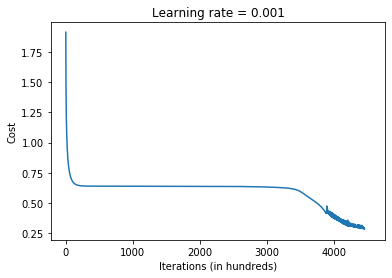

Ran 10000 iterations. Returning parameters now.
Parameters returned - dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'])
The final cost of the model after training was nan
The training accuracy was: 99.7%
Took 770.858943939209 seconds to train.
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'])


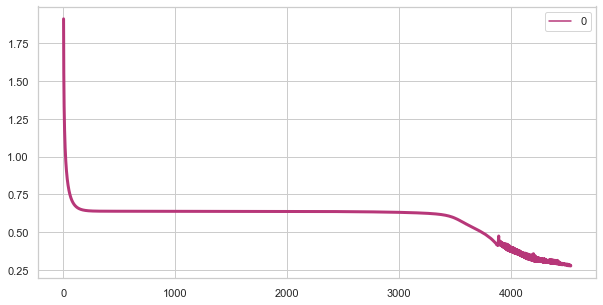

In [18]:
four_layer_parameters = four_layer_logistic(X_train_1, Y_train_1)
print(four_layer_parameters.keys())

In [20]:
# import csv
# with open('four_layer_parameters.csv', 'w') as f:
#     for key in four_layer_parameters.keys():
#         f.write("%s,%s\n"%(key,four_layer_parameters[key]))

In [50]:
X_dev_1 = X[:, 3000:3500]
Y_dev_1 = Y[3000:3500, :].T

In [43]:
dev_accuracy(X_dev_1, Y_dev_1, four_layer_parameters, architecture = [10, 5, 5, 1], activation_functions = ['relu', 'relu', 'relu', 'relu', 'sigmoid'])

The development set accuracy was 79.4%
